In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc 
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier

In [ ]:
# get data from SQL server

In [3]:
server = #enter server name and port (note, i took this out for security)
database = # enter database name (note, i took this out for security)
cnxn=pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=Yes')

predictit_data = pd.read_sql("""SELECT  * from predictit_matched_20240206""", cnxn)

cnxn.close()

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_5552\1276104261.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  predictit_data = pd.read_sql("""SELECT  * from predictit_matched_20240206""", cnxn)


# Data Pre-Processing Steps

In [4]:
#keep only the active users - dropping anyone who has not made any deposits or transactions on the site after creating initial log-in

for column in ['deposits', 'accountbalance', 'Withdrawals', 'Invested', 'riskamount', 'profit', 'loss','numshares']:
    predictit_data[column] = pd.to_numeric(predictit_data[column])
    
condition = (
    (predictit_data['deposits'] != 0) |
    (predictit_data['accountbalance'] != 0) |
    (predictit_data['Withdrawals'] != 0.00) |
    (predictit_data['Invested'] != 0.00) |
    (predictit_data['numshares'] != 0) |  
    (predictit_data['riskamount'] != 0.0000) |
    (predictit_data['profit'] != 0.000000) |
    (predictit_data['loss'] != 0.000000)
)

predictit_data = predictit_data[condition].copy()

I want to make the contrast between winners and losers as obvious as possible, as i think people who won a small amount or lost a small amount are just going to confuse the models. so i want to have my training data set consist of the top and bottom quartiles and leave out the middle two.

In [36]:
# Calculate the profit + loss in a new column
predictit_data['profit_loss'] = predictit_data['profit'] + predictit_data['loss']

# Find the 25th and 75th percentiles 
percentile_25 = predictit_data['profit_loss'].quantile(0.25)
percentile_75 = predictit_data['profit_loss'].quantile(0.75)

# Filter out the middle 50% of the dataset
top_25_percent = predictit_data[predictit_data['profit_loss'] > percentile_75]
bottom_25_percent = predictit_data[predictit_data['profit_loss'] < percentile_25]


using top and bottom quartiles modeling accuracy was in low 50s, so instead trying with the top and bottom x users (chose 6k)

In [126]:
#trying something a little different now since modeling with the top and bottom quanriles wasn't too good.

# Taking the 6000 records with the highest profit_loss from top_25_percent
top_records = top_25_percent.nlargest(6000, 'profit_loss')

# Taking the 6000 records with the lowest profit_loss from bottom_25_percent
bottom_records = bottom_25_percent.nsmallest(6000, 'profit_loss')

# Combine
filtered_predictit_data = pd.concat([top_records, bottom_records], ignore_index=True)

# Add winner column with 1 where 'profit_loss' > 0 (winners), 0 otherwise (losers)
filtered_predictit_data['winner'] = (filtered_predictit_data['profit_loss'] > 0).astype(int)



In [127]:
len(filtered_predictit_data)
filtered_predictit_data['winner'].value_counts()

1    6000
0    6000
Name: winner, dtype: int64

In [128]:
len(filtered_predictit_data)

12000

## data cleaning + feature engineering

In [129]:
#Replace blanks and spaces with NaN
filtered_predictit_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#consolidate SEX values due to some casing issues.
filtered_predictit_data['SEX'] = filtered_predictit_data['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})

# Mapping the PARTY_CODE to new groups to include inferred r / d as r & d  etc
party_code_mapping = {
    'R': 'Republican', 'S': 'Republican',
    'D': 'Democrat', 'E': 'Democrat',
    'N': 'No Affiliation', 'U': 'Unknown'
}

# If the party code is not in the mapping, assign as other
filtered_predictit_data['GROUPED_PARTY'] = filtered_predictit_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')

#make a unique county + state field
filtered_predictit_data['COUNTY_CODE'] = filtered_predictit_data['CENSUS_ST']+filtered_predictit_data['COUNTY_ST']




C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_5552\3908717612.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_predictit_data['GROUPED_PARTY'] = filtered_predictit_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_5552\3908717612.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_predictit_data['COUNTY_CODE'] = filtered_predictit_data['CENSUS_ST']+filtered_predictit_data['COUNTY_ST']


In [130]:
# Convert numeric fields to float and replace Y/ NaN with 1 / 0
for column in filtered_predictit_data.columns:
    # Attempt to convert column to numeric, coercing errors to NaN
    temp_series = pd.to_numeric(filtered_predictit_data[column], errors='coerce')
    # If the conversion did not result in all NaN values, the original column is numeric
    if not temp_series.isnull().all():
        filtered_predictit_data[column] = temp_series.astype(float)
    # Check for fields where the only values are 'Y' and NaN
    elif set(filtered_predictit_data[column].dropna().unique()) == {'Y'}:
        filtered_predictit_data[column] = filtered_predictit_data[column].map({'Y': 1, np.nan: 0}).astype(float)


In [131]:
#impute missing values
for column in filtered_predictit_data.columns:
    # Check if the column is numeric
    if filtered_predictit_data[column].dtype in ['float64', 'int64']:
        # Fill missing values with -1
        filtered_predictit_data[column].fillna(-1, inplace=True)
    else:
        # Fill missing values with "UNK"
        filtered_predictit_data[column].fillna("UNK", inplace=True)

In [132]:
#check to make sure we don't have any NaNs left

nan_columns = filtered_predictit_data.columns[filtered_predictit_data.isna().any()].tolist()

print("Columns with NaN values:", nan_columns)

Columns with NaN values: []


In [133]:
#double checking these columns are integers

filtered_predictit_data['ZIP'] = filtered_predictit_data['ZIP'].astype(int)
filtered_predictit_data['PARTY_MIX'] = filtered_predictit_data['PARTY_MIX'].astype(int)
filtered_predictit_data['COUNTY_CODE'] = filtered_predictit_data['COUNTY_CODE'].astype(int)

In [134]:
filtered_predictit_data.head()

,deposits,accountbalance,Withdrawals,Invested,numshares,riskamount,profit,loss,lastlogin,rowid,...,WATER,WEALTH,WOODWORK,WORKWOMAN,YEARBUILT,ZIP,profit_loss,winner,GROUPED_PARTY,COUNTY_CODE
0,400.0,454.695,-561000.00,0.00,10.0,9.000,978251.85,-318953.71,1.699404e+18,54914.0,...,-1.0,-1.0,0.0,0.0,-1.0,27516,659298.14,1.0,Democrat,37135
1,33945.0,0.009,-574123.37,0.00,0.0,0.000,1093006.61,-443942.27,1.700572e+18,103392.0,...,-1.0,-1.0,0.0,0.0,-1.0,19146,649064.34,1.0,Democrat,42101
2,8497.6,244.457,-495172.11,77.56,19794.0,2339.677,993440.06,-404980.58,1.700311e+18,214742.0,...,-1.0,7.0,0.0,0.0,2009.0,43062,588459.48,1.0,Democrat,39089
3,5225.0,11893.120,-420906.18,1253.70,50379.0,5908.338,680153.32,-177560.45,1.700409e+18,12908.0,...,-1.0,-1.0,0.0,0.0,-1.0,2453,502592.87,1.0,No Affiliation,25017
4,27450.0,8906.948,-302440.27,935.36,446781.0,12634.968,1054734.14,-652280.68,1.699682e+18,32502.0,...,3.0,-1.0,0.0,0.0,-1.0,92122,402453.46,1.0,No Affiliation,6073


## split data into target variable and features

I am going to train using some of the features identified as likely being important during the data explorations and visualation work

In [135]:

features_to_use = ['PASSPROSVAL','MEDHOMEVAL','AUTO_MSRP','ZIP','VTR_PPP84','VTR_PRI87','CNS_MEDINC','TOD_GOV_D_2020',
'TOD_GOV_R_2020','TOD_GOV_D_2012','TOD_GOV_R_2012','VTR_PRI88','TOD_GOV_R_2016','TOD_GOV_D_2016','VTR_PRI86',
'TOD_PRES_R_2020_PREC','TOD_PRES_R_2016_PREC','AUTO_MODEL','TOD_SEN_O_2012','TOD_GOV_DIFF_2020','TOD_PRES_D_2020_PREC',
'TOD_GOV_DIFF_2016','TOD_GOV_DIFF_2012','OCCDETAIL_DESC','OCCDETAIL','VTR_PPP88','TOD_PRES_D_2016_PREC',
'TOD_SEN_R_2014','TOD_SEN_D_2020','TOD_SEN_R_2020','PRFL_POLITICAL_IDEOLOGY','TOD_SEN_D_2014','PREVIOUS_PARTY',
'PARTY_CODE','TOD_GOV_D_2018','GROUPED_PARTY','TOD_SEN_D_2012','TOD_SEN_R_2016','TOD_GOV_O_2016','TOD_SEN_R_2012',
'TOD_GOV_R_2018','ALUMNI_INDUSTRY','TOD_PRES_D_2016','TOD_PRES_R_2020','PARTY_MIX','ETHNIC_INFER','INCOMESTHH','COUNTY_CODE']
 
X = filtered_predictit_data[features_to_use] 
y = filtered_predictit_data['winner']

In [136]:
#first split - validation set
X_temp, X_validation, y_temp, y_validation = train_test_split(X, y, test_size=0.1, random_state=42) # 10% for validation

#Second split: Splitting the remaining data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42) # 20% of 90% for testing

In [137]:
# Creating copies of the original datasets for CatBoost and maybe LightGBM
X_cb_lgbm = X.copy()
y_cb_lgbm = y.copy()

# First split
X_temp_cb_lgbm, X_validation_cb_lgbm, y_temp_cb_lgbm, y_validation_cb_lgbm = train_test_split(X_cb_lgbm, y_cb_lgbm, test_size=0.1, random_state=42) # 10% for validation

# Second split
X_train_cb_lgbm, X_test_cb_lgbm, y_train_cb_lgbm, y_test_cb_lgbm = train_test_split(X_temp_cb_lgbm, y_temp_cb_lgbm, test_size=0.2, random_state=42) # 20% of 90% for testing

## one hot encoding for categorical columns

In [138]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [139]:
categorical_columns  #double checking what my categorical columns are

['VTR_PRI88',
 'VTR_PRI86',
 'TOD_GOV_DIFF_2020',
 'TOD_GOV_DIFF_2016',
 'TOD_GOV_DIFF_2012',
 'OCCDETAIL_DESC',
 'OCCDETAIL',
 'VTR_PPP88',
 'PRFL_POLITICAL_IDEOLOGY',
 'PREVIOUS_PARTY',
 'PARTY_CODE',
 'GROUPED_PARTY',
 'ALUMNI_INDUSTRY',
 'ETHNIC_INFER',
 'INCOMESTHH']

In [140]:


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ], remainder='passthrough')  # 'passthrough' numerical features as is

# Apply the transformations
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
X_validation_encoded = preprocessor.transform(X_validation)


# Get feature names after one-hot encoding so i can use them later
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
# Combine with numerical features 
features_after_encoding = list(encoded_features) + [col for col in X_train.columns if col not in categorical_columns]

# Model evaluation

## Dummy Classifier

In [141]:
#train a dummy classifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_encoded, y_train)
y_pred = dummy_clf.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy of DummyClassifier: {accuracy}')

Baseline accuracy of DummyClassifier: 0.4912037037037037


## Logistic Regression

In [142]:
#initialize and train logistic regression model
lr_pipeline = make_pipeline(StandardScaler(with_mean =False), LogisticRegression(max_iter=10000))
lr_pipeline.fit(X_train_encoded, y_train)

# Evaluate the model on the test set
y_pred = lr_pipeline.predict(X_test_encoded)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.587037037037037
              precision    recall  f1-score   support

         0.0       0.58      0.59      0.59      1061
         1.0       0.60      0.58      0.59      1099

    accuracy                           0.59      2160
   macro avg       0.59      0.59      0.59      2160
weighted avg       0.59      0.59      0.59      2160



In [143]:
# Perform 5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(lr_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

# Print the average of the evaluation metrics across all 5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.609
Average Precision (macro): 0.609
Average F1-Score (macro): 0.609


In [145]:
#validation set testing
y_validation_pred = lr_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.5958333333333333
              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59       586
         1.0       0.61      0.59      0.60       614

    accuracy                           0.60      1200
   macro avg       0.60      0.60      0.60      1200
weighted avg       0.60      0.60      0.60      1200



In [146]:
#ok so logistic regression is doing a bit better than dummy classifier.

## Support Vector Machine

In [147]:

# Initialize / train SVM model
svm_pipeline = make_pipeline(StandardScaler(with_mean=False), SVC())
svm_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred = svm_pipeline.predict(X_test_encoded)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.586574074074074
              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62      1061
         1.0       0.62      0.49      0.55      1099

    accuracy                           0.59      2160
   macro avg       0.59      0.59      0.58      2160
weighted avg       0.59      0.59      0.58      2160



In [148]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(svm_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.598
Average Precision (macro): 0.600
Average F1-Score (macro): 0.595


In [149]:
#validation set testing
y_validation_pred = svm_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.5958333333333333
              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62       586
         1.0       0.63      0.51      0.57       614

    accuracy                           0.60      1200
   macro avg       0.60      0.60      0.59      1200
weighted avg       0.60      0.60      0.59      1200



In [ ]:
# about the same...

## Random Forest

In [150]:


# Initialize and train the Random Forest model
#rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_pipeline = RandomForestClassifier()
rf_pipeline.fit(X_train_encoded, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_pipeline.predict(X_test_encoded)
print("Random Forest Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Model Test Set Evaluation:
Accuracy: 0.5782407407407407
              precision    recall  f1-score   support

         0.0       0.56      0.62      0.59      1061
         1.0       0.59      0.54      0.57      1099

    accuracy                           0.58      2160
   macro avg       0.58      0.58      0.58      2160
weighted avg       0.58      0.58      0.58      2160



In [151]:
# 5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(rf_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.595
Average Precision (macro): 0.596
Average F1-Score (macro): 0.595


In [152]:
#validation set testing
y_validation_pred = rf_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.5958333333333333
              precision    recall  f1-score   support

         0.0       0.58      0.63      0.61       586
         1.0       0.62      0.56      0.59       614

    accuracy                           0.60      1200
   macro avg       0.60      0.60      0.60      1200
weighted avg       0.60      0.60      0.60      1200



In [ ]:
#about the same

## Gradient Boosting Classifier

In [153]:


# Initialize and train the Gradient Boosted Decision Tree model
#gbdt_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gbdt_pipeline =  GradientBoostingClassifier()
gbdt_pipeline.fit(X_train_encoded, y_train)

# Evaluate the model on the test set
y_pred_gbdt = gbdt_pipeline.predict(X_test_encoded)
print("Gradient Boosted Decision Tree Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))

Gradient Boosted Decision Tree Model Test Set Evaluation:
Accuracy: 0.5972222222222222
              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      1061
         1.0       0.61      0.58      0.59      1099

    accuracy                           0.60      2160
   macro avg       0.60      0.60      0.60      2160
weighted avg       0.60      0.60      0.60      2160



In [154]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(gbdt_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.610
Average Precision (macro): 0.610
Average F1-Score (macro): 0.610


In [155]:
#validation set testing
y_validation_pred = gbdt_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.6066666666666667
              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60       586
         1.0       0.62      0.60      0.61       614

    accuracy                           0.61      1200
   macro avg       0.61      0.61      0.61      1200
weighted avg       0.61      0.61      0.61      1200



In [ ]:
#bit better

## XG Boost

In [156]:


# Initialize and train  XGBoost model
xgb_pipeline = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred_xgb = xgb_pipeline.predict(X_test_encoded)
print("XGBoost Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Test Set Evaluation:
Accuracy: 0.5814814814814815
              precision    recall  f1-score   support

         0.0       0.57      0.60      0.58      1061
         1.0       0.59      0.57      0.58      1099

    accuracy                           0.58      2160
   macro avg       0.58      0.58      0.58      2160
weighted avg       0.58      0.58      0.58      2160



In [157]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(xgb_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

# metrics across 5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.594
Average Precision (macro): 0.594
Average F1-Score (macro): 0.594


In [158]:
#validation set testing
y_validation_pred = xgb_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.5825
              precision    recall  f1-score   support

         0.0       0.57      0.59      0.58       586
         1.0       0.59      0.58      0.59       614

    accuracy                           0.58      1200
   macro avg       0.58      0.58      0.58      1200
weighted avg       0.58      0.58      0.58      1200



## CatBoost

In [159]:


cat_features_indices = [X_train_cb_lgbm.columns.get_loc(c) for c in categorical_columns if c in X_train_cb_lgbm]

cat_model = CatBoostClassifier(iterations=1000, 
                               learning_rate=0.1, 
                               depth=10,
                               cat_features=cat_features_indices,
                               verbose=100)

# Train CatBoost model
cat_model.fit(X_train_cb_lgbm, y_train_cb_lgbm)

# Evaluate 
y_pred_cat = cat_model.predict(X_test_cb_lgbm)
print("CatBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_cb_lgbm, y_pred_cat))
print(classification_report(y_test_cb_lgbm, y_pred_cat))


0:	learn: 0.6879955	total: 157ms	remaining: 2m 37s
100:	learn: 0.4921093	total: 24.7s	remaining: 3m 40s
200:	learn: 0.3592215	total: 48.2s	remaining: 3m 11s
300:	learn: 0.2843494	total: 1m 12s	remaining: 2m 49s
400:	learn: 0.2315617	total: 1m 38s	remaining: 2m 26s
500:	learn: 0.1882061	total: 2m 6s	remaining: 2m 5s
600:	learn: 0.1565985	total: 2m 36s	remaining: 1m 43s
700:	learn: 0.1296218	total: 3m 2s	remaining: 1m 17s
800:	learn: 0.1102525	total: 3m 28s	remaining: 51.9s
900:	learn: 0.0949128	total: 3m 57s	remaining: 26.1s
999:	learn: 0.0822445	total: 4m 24s	remaining: 0us
CatBoost Test Set Evaluation:
Accuracy: 0.5703703703703704
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.57      1061
         1.0       0.58      0.57      0.58      1099

    accuracy                           0.57      2160
   macro avg       0.57      0.57      0.57      2160
weighted avg       0.57      0.57      0.57      2160



In [160]:
#validation set testing
y_validation_pred = cat_model.predict(X_validation_cb_lgbm)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.585
              precision    recall  f1-score   support

         0.0       0.57      0.59      0.58       586
         1.0       0.60      0.58      0.59       614

    accuracy                           0.58      1200
   macro avg       0.59      0.59      0.58      1200
weighted avg       0.59      0.58      0.59      1200



In [63]:
#  5-fold cross-validation
#scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
#cv_results = cross_validate(cat_model, X_train_cb_lgbm, y_train_cb_lgbm, cv=5, scoring=scoring)

# evaluation metrics across 5 folds
#print("5-Fold Cross-Validation Results:")
#print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
#print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
#print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

#this is just running super long and some of the other models performed better anyway so skipping it

## Grid Search for Parameter Tuning - Gradient Boosting Classifier

In [161]:


param_grid = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 3, 5],  
    'min_samples_leaf': [1, 2, 3],}

grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_encoded, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best score achieved:", grid_search.best_score_)

Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best score achieved: 0.6150462962962963


In [162]:
best_gbc = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 300)
best_gbc.fit(X_train_encoded, y_train)

# Evaluate the model on the test set
y_pred_rf = best_gbc.predict(X_test_encoded)
print("GBC Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

GBC Model Test Set Evaluation:
Accuracy: 0.5958333333333333
              precision    recall  f1-score   support

         0.0       0.58      0.61      0.60      1061
         1.0       0.61      0.58      0.59      1099

    accuracy                           0.60      2160
   macro avg       0.60      0.60      0.60      2160
weighted avg       0.60      0.60      0.60      2160



In [163]:
#validation set testing
y_validation_pred = best_gbc.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.6016666666666667
              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60       586
         1.0       0.62      0.59      0.60       614

    accuracy                           0.60      1200
   macro avg       0.60      0.60      0.60      1200
weighted avg       0.60      0.60      0.60      1200



## feature importances for GBC

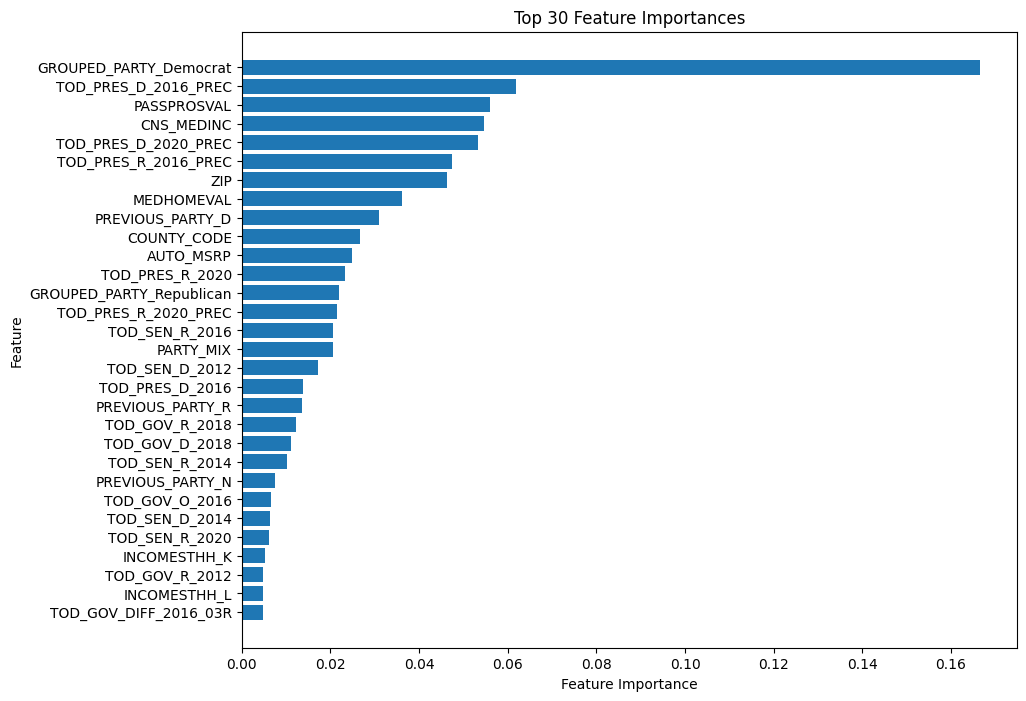

In [164]:

feature_importances = best_gbc.feature_importances_


feature_names = np.array(features_after_encoding) 

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[-30:]  #top 30 features

# Plot
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances")
plt.barh(range(30), feature_importances[sorted_idx], align='center')
plt.yticks(range(30), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()


## Learning Curve Analysis (GBC)

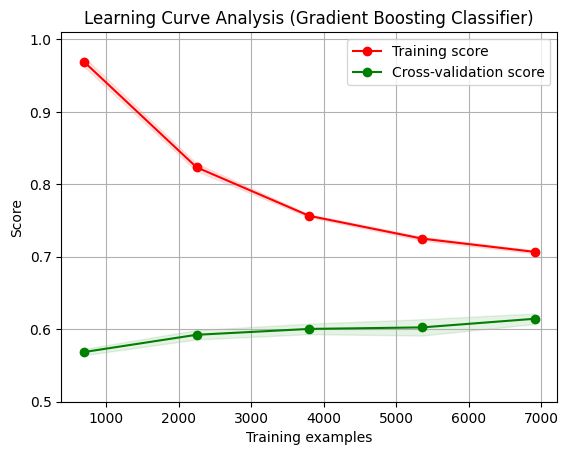

In [167]:
#note - chatGPT assisted with the code in cell block

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curve Analysis (Gradient Boosting Classifier)"
# Cross-validation with 5 splits
cv = 5
# Evaluate score on training and test set several times with different training set sizes
plot_learning_curve(best_gbc, title, X_train_encoded, y_train, ylim=(0.5, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [ ]:
#ok so this looks like there might continue to be some improvement with more training data, however, if i add more it will be for individuals with less impressive wins/losses
#so may not actually be helpful.

## ROC-AUC Curve

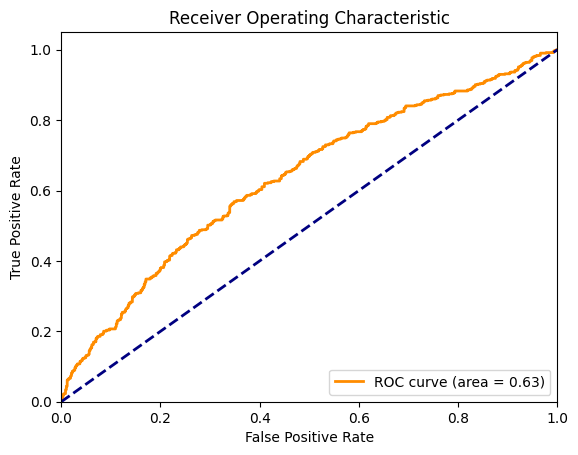

In [168]:
#Roc-AUC curve

# Compute the model's prediction probabilities
y_scores = best_gbc.predict_proba(X_validation_encoded)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_validation, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#as expected given the model's accuracy

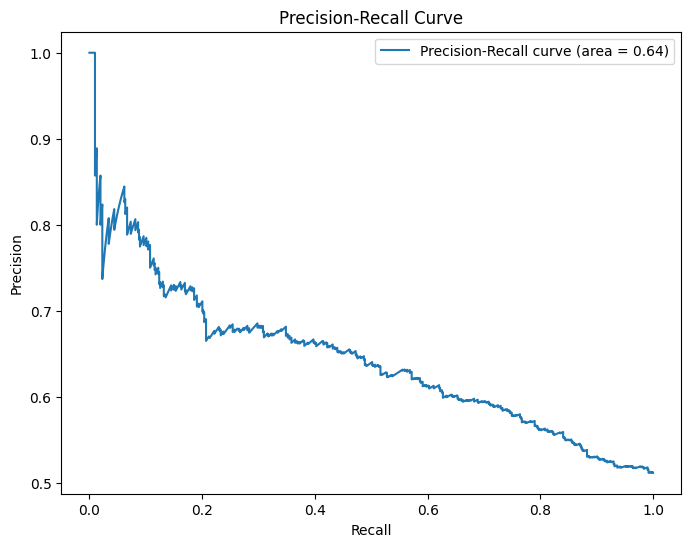

In [169]:


# Get the probability scores of  positive class
y_scores = best_gbc.predict_proba(X_validation_encoded)[:, 1]

# Calculate precision & recall 
precision, recall, thresholds = precision_recall_curve(y_validation, y_scores)

# Calculate the area under the curve 
auc_precision_recall = auc(recall, precision)

# Plot 
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()
